# Fraud Detection

In [0]:
import numpy as np
import pandas as pd
import bisect
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Collect data

In [0]:
data_raw=pd.read_csv('data/Fraud_Data.csv')
ip_mapping=pd.read_csv('data/IpAddress_to_Country.csv')

In [25]:
data_raw.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [26]:
ip_mapping.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [27]:
data_raw.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

# Map each ip address to each corresonding country.

Convert feature ip_address,lower_bound_ip_address and upper_bound_ip_address to numeric type.

In [0]:
data_raw['ip_address']=data_raw['ip_address'].astype(np.int64)
ip_mapping['lower_bound_ip_address']=ip_mapping['lower_bound_ip_address'].astype(np.int64)
ip_mapping['upper_bound_ip_address']=ip_mapping['upper_bound_ip_address'].astype(np.int64)

Get country by ip address

In [0]:
def get_country(x):
    country=ip_mapping[(ip_mapping['lower_bound_ip_address']<x)&
                       (ip_mapping['upper_bound_ip_address']>x)]['country'].values
    if country.shape[0]>0:
        return country[0]
    else:
        return np.NaN

Query country and add into data

In [0]:
data_raw['country']=data_raw['ip_address'].map(get_country)

In [31]:
data_raw.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States


Check overview data.

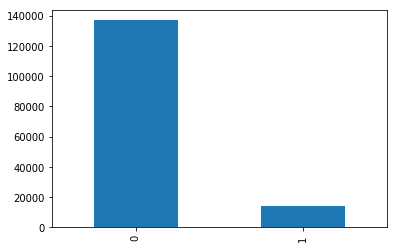

In [32]:
data_raw['class'].value_counts().plot(kind='bar')

Imbalanced data!

In [33]:
data_raw.nunique()/data_raw.shape[0]

user_id           1.000000
signup_time       1.000000
purchase_time     0.997135
purchase_value    0.000807
device_id         0.912939
source            0.000020
browser           0.000033
sex               0.000013
age               0.000384
ip_address        0.949693
class             0.000013
country           0.001198
dtype: float64

Covert to datetime

In [0]:
data_raw['signup_time']=pd.to_datetime(data_raw['signup_time'])
data_raw['purchase_time']=pd.to_datetime(data_raw['purchase_time'])

Get difference between sign-up time and purchase time in minute


In [35]:
data_raw['difference']=data_raw['purchase_time']-data_raw['signup_time']
data_raw['difference']=data_raw['difference'].astype('timedelta64[m]')
data_raw.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,75111.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,299.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NaN,8201.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,72691.0


Extract hour

In [0]:
data_raw['signup_hour']=data_raw['signup_time'].dt.hour
data_raw['purchase_hour']=data_raw['purchase_time'].dt.hour

Get day of week

In [0]:
data_raw['signup_dayofweek']=data_raw['signup_time'].dt.strftime('%A')
data_raw['purchase_dayofweek']=data_raw['purchase_time'].dt.strftime('%A')

Count device and ip address that each user used

In [38]:
u, indices, counts=np.unique(data_raw['device_id'], return_inverse=True, return_counts=True)
data_raw['device_id_count']=counts[indices]
data_raw.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference,signup_hour,purchase_hour,signup_dayofweek,purchase_dayofweek,device_id_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,75111.0,22,2,Tuesday,Saturday,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,299.0,20,1,Sunday,Monday,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,0.0,18,18,Thursday,Thursday,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NaN,8201.0,21,13,Tuesday,Monday,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,72691.0,7,18,Tuesday,Wednesday,1


In [39]:
u, indices, counts=np.unique(data_raw['ip_address'], return_inverse=True, return_counts=True)
data_raw['ip_address__count']=counts[indices]
data_raw.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference,signup_hour,purchase_hour,signup_dayofweek,purchase_dayofweek,device_id_count,ip_address__count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,75111.0,22,2,Tuesday,Saturday,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,299.0,20,1,Sunday,Monday,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,0.0,18,18,Thursday,Thursday,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NaN,8201.0,21,13,Tuesday,Monday,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,72691.0,7,18,Tuesday,Wednesday,1,1


Map value of device_id, country, sex, source, browser and dayofweek to number

In [43]:
factor_list=['device_id', 'source', 'browser', 'sex', 'country', 'signup_dayofweek', 'purchase_dayofweek']
key=factor_list[:]
for i, variable in enumerate(factor_list):
  data_raw[variable], key[i]=data_raw[variable].factorize(sort=True)
  
data_raw.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,difference,signup_hour,purchase_hour,signup_dayofweek,purchase_dayofweek,device_id_count,ip_address__count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,89215,2,0,1,39,732758368,0,84,75111.0,22,2,5,2,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,24078,0,0,0,53,350311387,0,171,299.0,20,1,3,1,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,131216,2,3,1,53,2621473820,1,171,0.0,18,18,4,4,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,3977,2,4,1,41,3840542443,0,-1,8201.0,21,13,5,1,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,68757,0,4,1,45,415583117,0,171,72691.0,7,18,5,6,1,1


Drop unused columns

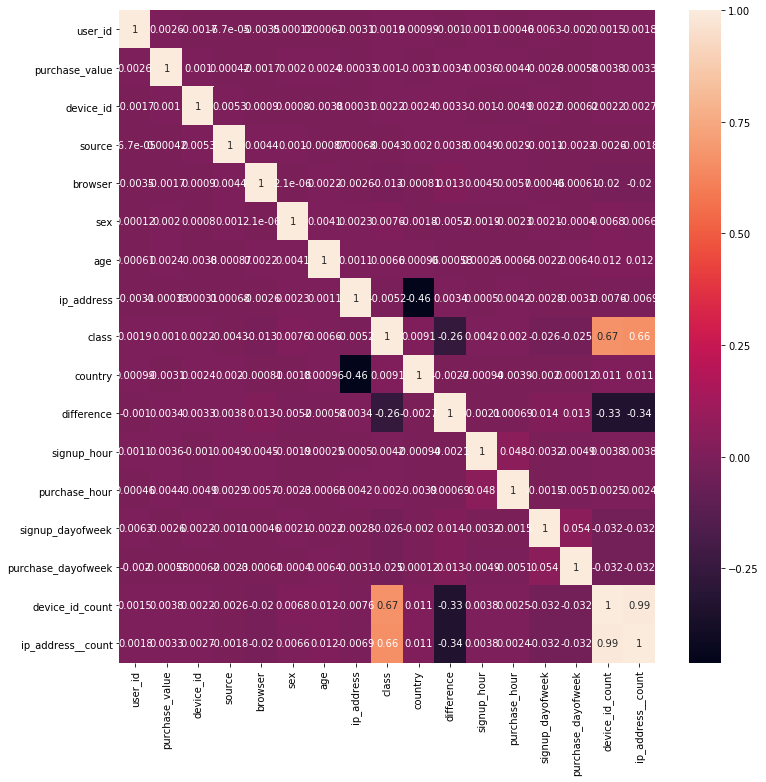

In [44]:
plt.figure(figsize=(12,12))
sns.heatmap(data_raw.corr(), annot=True)

In [45]:
data_raw.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'difference', 'signup_hour', 'purchase_hour',
       'signup_dayofweek', 'purchase_dayofweek', 'device_id_count',
       'ip_address__count'],
      dtype='object')

In [0]:
X=data_raw.drop(['user_id', 'signup_time','purchase_time' ,'class'],axis=1)
y=data_raw['class']

In [47]:
X.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,difference,signup_hour,purchase_hour,signup_dayofweek,purchase_dayofweek,device_id_count,ip_address__count
0,34,89215,2,0,1,39,732758368,84,75111.0,22,2,5,2,1,1
1,16,24078,0,0,0,53,350311387,171,299.0,20,1,3,1,1,1
2,15,131216,2,3,1,53,2621473820,171,0.0,18,18,4,4,12,12
3,44,3977,2,4,1,41,3840542443,-1,8201.0,21,13,5,1,1,1
4,39,68757,0,4,1,45,415583117,171,72691.0,7,18,5,6,1,1


Using classifier algorithms of sklearn

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [0]:
X_train, X_test, y_train, y_test=train_test_split(X,y)

In [65]:
X_train.shape

(113334, 15)

In [66]:
y_train.shape

(113334,)

Using KNN to train

In [67]:
knn_clf=KNeighborsClassifier()
para={'n_neighbors':[i for i in range(1,10,1)]}
grid_knn_clf=GridSearchCV(knn_clf, param_grid=para, scoring='roc_auc')
grid_knn_clf.fit(X_train,y_train)
grid_knn_clf.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7658469394860767

Using random forest

In [68]:
rff_clf=RandomForestClassifier()
para={'max_depth': [i for i in range(3,20,1)]}
grid_rff_clf=GridSearchCV(rff_clf, param_grid=para, scoring='roc_auc')
grid_rff_clf.fit(X_train,y_train)
grid_rff_clf.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245:

0.8446905353123021

In [69]:
dt_clf=DecisionTreeClassifier()
para={'max_depth': [i for i in range(3,20,1)]}
grid_dt_clf=GridSearchCV(dt_clf, param_grid=para, scoring='roc_auc')
grid_dt_clf.fit(X_train,y_train)
grid_dt_clf.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.843152894015735

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
% matplotlib inline
y_pred_knn=grid_knn_clf.predict(X_test)
y_pre_pro_knn=grid_knn_clf.predict_proba(X_test)


y_pre_rff=grid_rff_clf.predict(X_test)
y_pre_pro_rff=grid_rff_clf.predict_proba(X_test)

y_pre_dt=grid_dt_clf.predict(X_test)
y_pre_pro_dt=grid_dt_clf.predict_proba(X_test)


fpr_knn, tpr_knn, thre_knn=roc_curve(y_test, y_pre_pro_knn[:,1])
roc_auc_knn=auc(fpr_knn,tpr_knn)
fpr_rff, tpr_rff, thre_rff=roc_curve(y_test, y_pre_pro_rff[:,1])
roc_auc_rff=auc(fpr_rff,tpr_rff)
fpr_dt, tpr_dt, thre_dt=roc_curve(y_test, y_pre_pro_dt[:,1])
roc_auc_dt=auc(fpr_dt, tpr_dt)

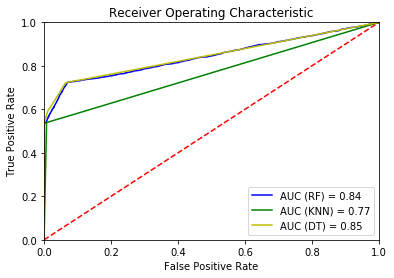

In [80]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rff, tpr_rff, 'b', label='AUC (RF) = %0.2f' % roc_auc_rff)
plt.plot(fpr_knn, tpr_knn, 'g', label='AUC (KNN) = %0.2f' % roc_auc_knn)
plt.plot(fpr_dt, tpr_dt, 'y', label='AUC (DT) = %0.2f' % roc_auc_dt)
plt.legend(loc='lower right')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()